In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys; sys.path.append('..')
import os, random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'
zx.todd.TOPT_LOCATION = os.path.expanduser("~/projects/pyzx/TOpt")

In [118]:
circ_name = r'../circuits/Arithmetic_and_Toffoli/barenco_tof_5_before'
#circ_name = r'..\circuits\Other\hwb6.qc'
c_orig = zx.Circuit.load(circ_name).to_basic_gates()
print(c_orig.stats())
g = c_orig.to_graph()
zx.simplify.full_reduce(g)
circuit = zx.extract.streaming_extract(g)
print(circuit.to_basic_gates().stats())
#circuit.gates
#zx.draw(circuit, figsize=(20,4))

Circuit barenco_tof_5_before on 9 qubits with 194 gates.
        84 T-like gates
        110 Cliffords among which 
        72 2-qubit gates and 38 Hadamard gates.
Circuit  on 9 qubits with 436 gates.
        40 T-like gates
        396 Cliffords among which 
        209 2-qubit gates and 174 Hadamard gates.


In [119]:
from pyzx.optimize import Optimizer, phase_block_optimize
o = Optimizer(circuit.to_basic_gates())
#o = Optimizer(c_orig.to_basic_gates())
c = o.parse_circuit(separate_correction=False, quiet=False)
print(c.stats())
#zx.draw(c, figsize=(60,5))#,rows=(0,100))

1.2.Circuit  on 9 qubits with 291 gates.
        40 T-like gates
        251 Cliffords among which 
        190 2-qubit gates and 33 Hadamard gates.


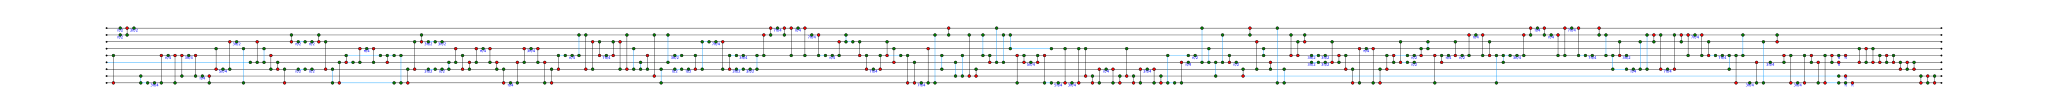

In [129]:
zx.draw(c, figsize=(60,3))

In [122]:
#zx.todd.TOPT_LOCATION = os.path.expanduser("~/projects/pyzx/TOpt")
zx.todd.TOPT_LOCATION = None
%prun c2 = phase_block_optimize(c, quiet=False)
print(c2.stats())
#zx.draw(c2, figsize=(60,5))

1.new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
new block
 Circuit  on 9 qubits with 308 gates.
        40 T-like gates
        268 Cliffords among which 
        199 2-qubit gates and 33 Hadamard gates.


In [123]:
zx.compare_tensors(c, c2)

True

In [121]:
o = Optimizer(c2.to_basic_gates())
c = o.parse_circuit()
print(c.stats())

Circuit  on 24 qubits with 3787 gates.
        171 T-like gates
        3616 Cliffords among which 
        3123 2-qubit gates and 128 Hadamard gates.


In [24]:
zx.compare_tensors(c2, c_orig)

True

In [40]:
from pyzx.todd import phase_gates_to_poly, remove_trivial_cols
gates = [g for g in c2.gates if g.name != 'HAD']
phase_poly, parity_polys = phase_gates_to_poly(gates, 15)
m = phase_poly.to_par_matrix()
m = m.transpose()
remove_trivial_cols(m)
m = m.transpose()
m2 = m.copy()
print(sum(sum(r) for r in m2.data))
minimize_ones(m2)
print(sum(sum(r) for r in m2.data))
#m2.gauss(full_reduce=True)
m2 = m2.transpose()
data = [r for r in m2.data if sum(r) <= 4]
print(len(data))
bad_cols = [i for i,r in enumerate(m2.data) if sum(r) > 6]
print(bad_cols)
m2 = m2.transpose()
minimize_ones(m2, bad_cols)
print(sum(sum(r) for r in m2.data))
m2 = m2.transpose()
data = [r for r in m2.data if sum(r) <= 4]
print(len(data))
m3 = zx.linalg.Mat2(data).transpose()
print(m3)

550
402
43
[9, 21, 40, 44, 47, 56, 77, 86]
402
43
[ 0  0  1  0  1  0  0  0  0  0  0  0  0  1  1  1  1  1  0  1  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0 ]
[ 0  0  0  0  0  0  0  0  1  1  0  0  0  0  1  0  1  0  0  1  1  0  1  0  0  1  1  0  0  1  0  1  0  0  0  0  0  0  0  1  0  0  0 ]
[ 1  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  1  0  0  0  1  0  1  1  1 ]
[ 0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  1  0  1  0  1  0  0  1  0  0 ]
[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  1  1  0  1  0  0  0  0  0  0  1  1  0  1  1  1  0  0  0  0  0  0  0  0  0  1  0  0 ]
[ 0  1  1  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ]
[ 0  0  0  1  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  1  0  0  0  0  0  0  1  0  1  0  0  0  1  0  1  0  0  0  1 ]
[ 0  0  0  0  1  0  0  1  

In [109]:
m3.cols()

24

In [16]:
import itertools

def minimize_ones(m, ignore_cols=[]):
    rows = m.rows()
    while True:
        for a in range(rows):
            r1 = m.data[a]
            s1 = sum(1 for i,v in enumerate(r1) if v and i not in ignore_cols)
            should_break = False
            for b in range(a+1,rows):
                r2 = m.data[b]
                s2 = sum(1 for i,v in enumerate(r2) if v and i not in ignore_cols)
                if sum(1 for s,t in zip(r1,r2) if s+t==1) < max(s1,s2):
                    if s1 > s2:
                        m.row_add(b,a)
                    else: m.row_add(a,b)
                    should_break = True
                    break
            if should_break: break
        else:
            break

def pick_rows(m):
    m2 = m.transpose()
    data = [r for r in m2.data if sum(r) <= 4]
    m = zx.linalg.Mat2(data).transpose()
    rows = m.rows()
    cols = m.cols()
    for a in range(rows):
        r1 = m.data[a]
        if sum(r1) < 3: continue
        for b in range(a+1,rows):
            #print(a,b)
            r2 = m.data[b]
            if sum(r2) < 3: continue
            other_rows = set()
            for i,v in enumerate(r1):
                if not v: continue
                for c in range(rows):
                    if m.data[c][i]: other_rows.add(c)
            for i,v in enumerate(r2):
                if not v: continue
                for c in range(rows):
                    if m.data[c][i]: other_rows.add(c)
            other_rows.discard(a)
            other_rows.discard(b)
            for c,d in itertools.combinations(other_rows, 2):
                correct_cols = []
                bad_cols = []
                neg_cols = []
                targets = {a,b,c,d}
                s = set(range(rows))
                s.remove(a)
                s.remove(b)
                s.remove(c)
                s.remove(d)
                for col in range(cols):
                    v = sum(m.data[i][col] for i in s)
                    if not v:
                        correct_cols.append([m.data[i][col] for i in range(rows)])
                    elif v == 1:
                        bad_cols.append([m.data[i][col] for i in range(rows)])
                    v = sum(m.data[i][col] for i in targets)
                    if not v:
                        neg_cols.append([m.data[i][col] for i in range(rows)])
                if len(correct_cols) > 7:
                    return a,b,c,d, correct_cols
                if len(correct_cols) > 6:
                    print("almost")
                    print(a,b,c,d)
                    data = correct_cols.copy()
                    data.extend(bad_cols)
                    data.extend(neg_cols)
                    m3 = zx.linalg.Mat2(data).transpose()
                    print(m3)

In [41]:
pick_rows(m3)

In [48]:
m2 = m.copy()
minimize_ones(m2)
print(m2)

[ 0  0  0  0  0  0  0  0  1  0  0  1  1  0  0  0  0  1  0  0  0  1  0  1  0  0  0  1  0  1  0  1  1  0  0  0  0  1  0  0  1  0  0  0  0  1  0  0  1  1  1  0  1  1  0 ]
[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  1  0  1  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0 ]
[ 0  1  0  1  0  0  0  1  1  1  1  1  0  1  0  0  0  1  1  0  0  1  0  0  0  1  1  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  1  0  0  0  1  0  0  0  0  0  0  0 ]
[ 1  0  1  1  0  1  0  0  0  0  1  0  1  0  0  0  0  0  0  1  0  0  0  1  1  0  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0  0  0  0  1  0  0  0  1  0  0  1  1  1  0 ]
[ 0  0  1  0  0  1  0  1  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  1  0  0  0  0  1  0 ]
[ 0  0  0  0  1  0  0  0  0  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0 

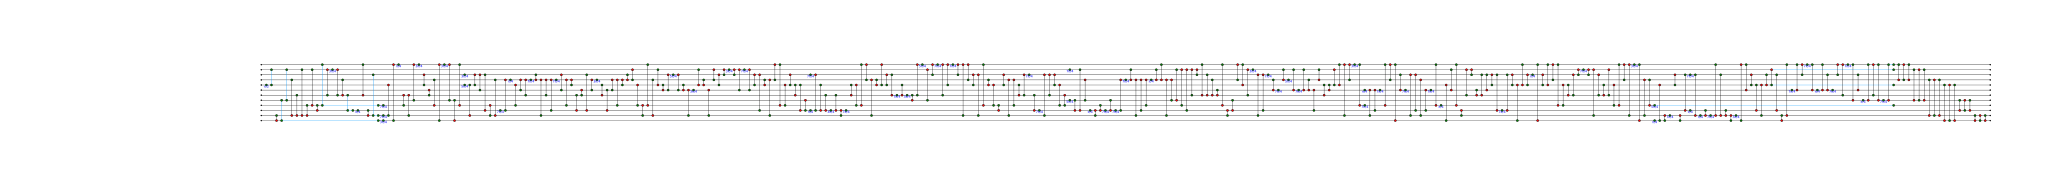

In [13]:
zx.draw(c, figsize=(70,6))

In [ ]:
from pyzx.todd import todd_simp

In [212]:
zx.compare_tensors(c, circuit)

False

succes!
True True


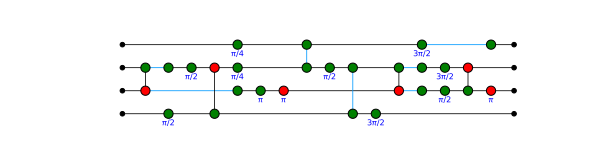

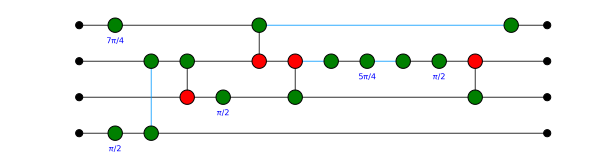

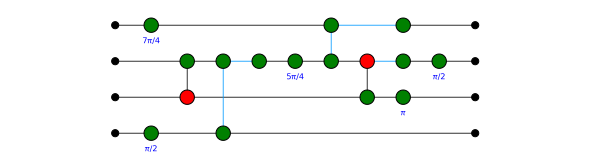

In [254]:
from pyzx.circuit import T
def generate_clifford():
    g = zx.generate.cliffords(4,9)
    zx.simplify.to_gh(g)
    return Optimizer(zx.Circuit.from_graph(g)).parse_circuit(1)

i = 0
while True:
    i += 1
    if i%50 == 0:
        print(i, end='.')
    c1 = generate_clifford()
    c2 = generate_clifford()
    c1.add_gate(T(0))
    c1.add_gate(T(1))
    c1.add_circuit(c2)
    g = c1.to_graph()
    zx.simplify.clifford_simp(g,quiet=True)
    c2 = zx.extract.streaming_extract(g)
    o = Optimizer(c2.to_basic_gates())
    c2 = o.parse_circuit()
    c3 = Optimizer(c1).parse_circuit()
    if not zx.compare_tensors(c1,c3):
        print("Errawr")
        break
    #c3 = Optimizer(c3).parse_circuit()
    c3, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
    c3 = Optimizer(c3).parse_circuit()
    if not zx.compare_tensors(c1,c3):
        print("Errawr2")
        break
    #c3 = Optimizer(c3).parse_circuit()
#     c3, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
#     c3 = Optimizer(c3).parse_circuit()
    two_qubit = sum(1 for g in c3.gates if g.name in ('CZ', 'CNOT'))
    if two_qubit < 6 and len(c2.gates) < len(c3.gates) and sum(1 for g in c2.gates if g.name in ('CZ', 'CNOT')) < two_qubit:
        print("succes!")
        break

print(zx.compare_tensors(c1,c2),zx.compare_tensors(c1,c3))
display(zx.draw(c1))
display(zx.draw(c3))
display(zx.draw(c2))

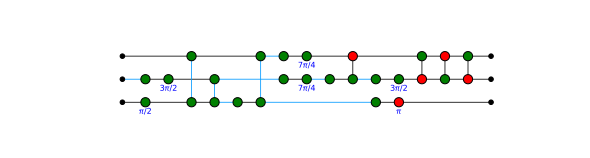

Match!
CZ(1,2) CNOT(1,2)
[CNOT(2,0)] [CNOT(1,2)]
[CNOT(1,2), CNOT(2,0)] [CNOT(0,1), ZPhase(1,phase=7/4), HAD(1), CNOT(1,2)]
[CNOT(2,0), S(2)] [CNOT(1,2), S(1)]
[S*(2), CNOT(1,2), CNOT(2,0), S(2)] [CNOT(0,1), ZPhase(1,phase=7/4), HAD(1), CNOT(1,2), S(1)]
[9.7, 9.8, 10, 11] [4, 5, 8, 9.8, 12]


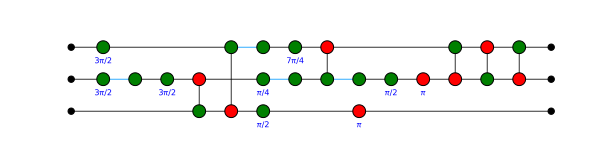

In [244]:
g = c1.to_graph()
zx.simplify.clifford_simp(g,quiet=True)
c2 = zx.extract.streaming_extract(g)
#c4 = c1.copy()
#c4.gates = list(reversed(c4.gates))
o = Optimizer(c1)
#o.minimize_czs = True
display(zx.draw(o.parse_forward()))
c3 = o.parse_circuit()
#display(zx.draw(c1))
zx.draw(c3)

In [245]:
zx.compare_tensors(c1,c3)

True

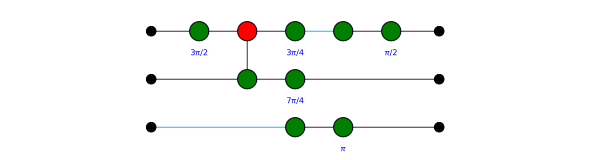

In [182]:
c3 = Optimizer(c3.to_basic_gates()).parse_circuit()
zx.draw(c3)